In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


In [2]:
torch.manual_seed(42)

# This line is written using AI 
# Normalize Fashion-MNIST to mean=0.5, std=0.5
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Download Fashion-MNIST data and save it locally (60,000 images)
full_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform )




In [3]:
print('Type of the downloaded data', type(full_dataset))
img, label = full_dataset[0]
print(type(img))    # <class 'torch.Tensor'>
print(img.shape)    # torch.Size([1, 28, 28])
print(type(label))  # <class 'int'>

Type of the downloaded data <class 'torchvision.datasets.mnist.FashionMNIST'>
<class 'torch.Tensor'>
torch.Size([1, 28, 28])
<class 'int'>


In [4]:

# 70% training (36,000), 30% validation (24,000)
train_size = int(0.7 * len(full_dataset))
valid_size = len(full_dataset) - train_size

train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

# Using the Official test set from Fashion-MNIST(10,000 images)
test_dataset = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.pool_1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.pool_2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        self.fc = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool_1(x)

        x = F.relu(self.conv2(x))
        x = self.pool_2(x)

        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x

In [6]:
import time

def train_model(model, train_loader, valid_loader, epochs=20, learning_rate=0.01):
    """
    Train and evaluate a CNN model with PyTorch DataLoaders.
    """

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    train_costs, train_accuracies = [], []
    valid_costs, valid_accuracies = [], []

    start = time.perf_counter()

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_costs.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # ---- Validation ----
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        valid_costs.append(val_loss / len(valid_loader))
        valid_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss = {train_costs[-1]:.4f}, Train Acc = {train_accuracies[-1]:.2f}%, "
              f"Valid Loss = {valid_costs[-1]:.4f}, Valid Acc = {valid_accuracies[-1]:.2f}%")

    end = time.perf_counter()
    training_time = end - start

    return train_costs, train_accuracies, valid_costs, valid_accuracies, training_time


In [8]:
model = CNN()
train_costs, train_acc, valid_costs, valid_acc, training_time = train_model(
    model, train_loader, valid_loader, epochs=100, learning_rate=0.01
)


Epoch 1/100: Train Loss = 0.4597, Train Acc = 83.43%, Valid Loss = 0.4037, Valid Acc = 85.16%
Epoch 2/100: Train Loss = 0.3514, Train Acc = 87.37%, Valid Loss = 0.3335, Valid Acc = 88.03%
Epoch 3/100: Train Loss = 0.3243, Train Acc = 88.42%, Valid Loss = 0.3384, Valid Acc = 88.18%
Epoch 4/100: Train Loss = 0.3124, Train Acc = 88.83%, Valid Loss = 0.3606, Valid Acc = 87.41%
Epoch 5/100: Train Loss = 0.3063, Train Acc = 89.00%, Valid Loss = 0.3583, Valid Acc = 87.41%
Epoch 6/100: Train Loss = 0.3067, Train Acc = 88.75%, Valid Loss = 0.3311, Valid Acc = 88.34%
Epoch 7/100: Train Loss = 0.3021, Train Acc = 89.05%, Valid Loss = 0.3723, Valid Acc = 87.39%
Epoch 8/100: Train Loss = 0.2922, Train Acc = 89.46%, Valid Loss = 0.3321, Valid Acc = 88.04%
Epoch 9/100: Train Loss = 0.2925, Train Acc = 89.44%, Valid Loss = 0.3561, Valid Acc = 86.96%
Epoch 10/100: Train Loss = 0.2924, Train Acc = 89.41%, Valid Loss = 0.3617, Valid Acc = 86.87%
Epoch 11/100: Train Loss = 0.2875, Train Acc = 89.66%, Vali

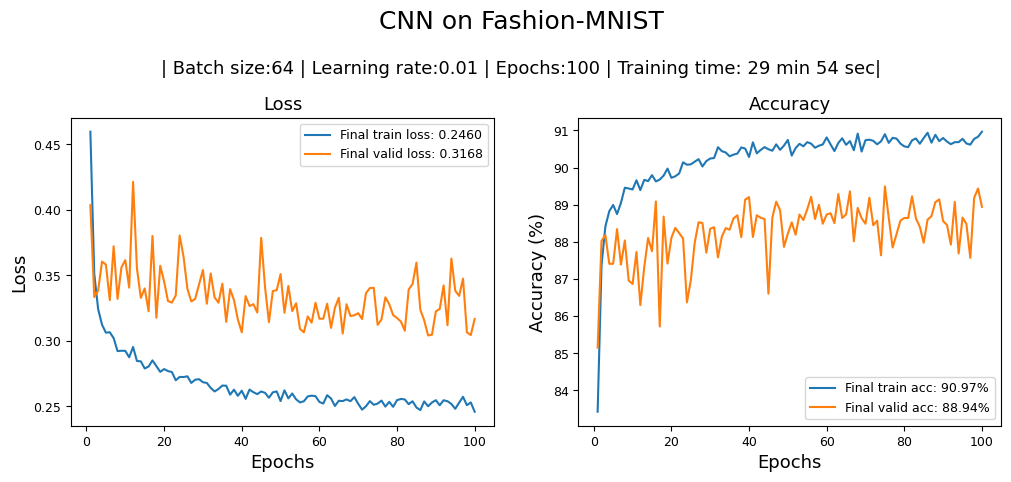

In [9]:
from matplotlib import pyplot as plt
import numpy as np

def training_curve_plot(title, train_costs, valid_costs, train_accuracies, valid_accuracies, batch_size, learning_rate, training_time, epochs):
    lg=18
    md=13
    sm=9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    
    mins, secs = divmod(training_time, 60)
    sub = f'| Batch size:{batch_size} | Learning rate:{learning_rate} | Epochs:{epochs} | Training time: {int(mins)} min {secs:.0f} sec|'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    
    x = range(1, len(train_costs)+1)

    # ---- Loss plot ----
    axs[0].plot(x, train_costs, label=f'Final train loss: {train_costs[-1]:.4f}')
    axs[0].plot(x, valid_costs, label=f'Final valid loss: {valid_costs[-1]:.4f}')
    axs[0].set_title('Loss', fontsize=md)
    axs[0].set_xlabel('Epochs', fontsize=md)
    axs[0].set_ylabel('Loss', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)

    # ---- Accuracy plot ----
    axs[1].plot(x, train_accuracies, label=f'Final train acc: {train_accuracies[-1]:.2f}%')
    axs[1].plot(x, valid_accuracies, label=f'Final valid acc: {valid_accuracies[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Epochs', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=md)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)

    plt.show()
training_curve_plot(
    "CNN on Fashion-MNIST",
    train_costs,      # training loss
    valid_costs,      # validation loss (instead of test)
    train_acc,        # training accuracy
    valid_acc,        # validation accuracy (instead of test)
    batch_size=64,
    learning_rate=0.01,
    training_time=training_time,
    epochs=100
)
